C:\Users\zhang\AppData\Local\Temp\ipykernel_49612\1903973191.py:46: DeprecationWarning: `kron` has been deprecated in favour of `numpy.kron` in SciPy 1.15.0 and will be removed in SciPy 1.17.0.
  A = block_diag(kron(np.eye(T-1),A_t), np.zeros_like(A_t))
C:\Users\zhang\AppData\Local\Temp\ipykernel_49612\1903973191.py:47: DeprecationWarning: `kron` has been deprecated in favour of `numpy.kron` in SciPy 1.15.0 and will be removed in SciPy 1.17.0.
  B = block_diag(kron(np.eye(T-1),B_t), np.zeros_like(B_t))
C:\Users\zhang\AppData\Local\Temp\ipykernel_49612\1903973191.py:48: DeprecationWarning: `kron` has been deprecated in favour of `numpy.kron` in SciPy 1.15.0 and will be removed in SciPy 1.17.0.
  C = block_diag(kron(np.eye(T-1),C_t), np.zeros_like(C_t))
C:\Users\zhang\AppData\Local\Temp\ipykernel_49612\1903973191.py:56: DeprecationWarning: `kron` has been deprecated in favour of `numpy.kron` in SciPy 1.15.0 and will be removed in SciPy 1.17.0.
  Z = kron(np.diag(np.ones(T-1),-1), np.eye(

                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Sep 11 10:34:15 AM: Applying reduction ConeMatrixStuffing
(CVXPY) Sep 11 10:34:15 AM: Applying reduction GUROBI
(CVXPY) Sep 11 10:34:15 AM: Finished problem compilation (took 8.215e-01 seconds).
(CVXPY) Sep 11 10:34:15 AM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i9-13980HX, instruction set [SSE2|AVX|AVX2]
Thread count: 24 physical cores, 32 logical processors, using up to 32 threads

Non-default parameters:
QCPDual  1

Optimize a model with 16242 rows, 8625 columns and 37138 nonzeros
Model fingerprint: 0x985687ca
Model has 29 quadratic constraints
Variable types: 8585 continuous, 40 integer (40 binary)
Coefficient statistics:
  Matrix range     [2e-02, 1e+04]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e-01, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]

No start values specified in

(CVXPY) Sep 11 10:34:21 AM: Problem status: optimal
(CVXPY) Sep 11 10:34:21 AM: Optimal value: 1.584e+02
(CVXPY) Sep 11 10:34:21 AM: Compilation took 8.215e-01 seconds
(CVXPY) Sep 11 10:34:21 AM: Solver (including time spent in interface) took 5.224e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


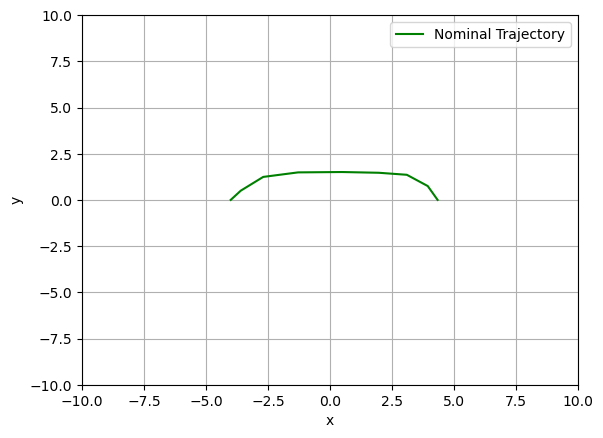

In [3]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.linalg import block_diag, kron
import scipy.io as sio
import os
# Parameters
T = 10
Ts = 0.5
state_dim = 4
input_dim = 2
output_dim = 2
disturbance_level_dyn = 0.05
disturbance_level_output = 0.02
response_matrix_bnd = 1e2
Dx = np.eye(state_dim)*disturbance_level_dyn
Dy = np.eye(output_dim)*disturbance_level_output

# The bound of the obstacle box
xu = 3.4
yu = 1
xl = 3.4
yl = 1

x_init = np.array([[-4.0], [-0.0], [0.0], [0.0]])  # Initial state
x_terminal = np.array([[4.0], [0.0], [0.0], [0.0]])  # Terminal state


# Dynamics matrices
A_t = np.array([[1, 0, Ts, 0],
                [0, 1, 0, Ts],
                [0, 0, 1, 0],
                [0, 0, 0, 1]], dtype=np.float32)
B_t = np.array([[0, 0],
                [0, 0],
                [Ts, 0],
                [0, Ts]], dtype=np.float32)
C_t = np.array([[1, 0, 0, 0],
                [0, 1, 0, 0]], dtype=np.float32)

# Block-diagonal matrices A, B, C
matrices_A = [A_t if i < T - 1 else np.zeros_like(A_t) for i in range(T)]
matrices_B = [B_t if i < T - 1 else np.zeros_like(B_t) for i in range(T)]
matrices_C = [C_t if i < T - 1 else np.zeros_like(C_t) for i in range(T)]

A = block_diag(kron(np.eye(T-1),A_t), np.zeros_like(A_t))
B = block_diag(kron(np.eye(T-1),B_t), np.zeros_like(B_t))
C = block_diag(kron(np.eye(T-1),C_t), np.zeros_like(C_t))

Id = np.eye(T * state_dim)

# Create Z operator (block downshift)
# Z = np.zeros((T * state_dim, T * state_dim))
# for i in range(1, T):
#     Z[i * state_dim:(i + 1) * state_dim, (i - 1) * state_dim:i * state_dim] = np.eye(state_dim)
Z = kron(np.diag(np.ones(T-1),-1), np.eye(state_dim))

# Define decision variables
phi_xw = cp.Variable((T * state_dim, T * state_dim))
phi_uw = cp.Variable((T * input_dim, T * state_dim))
phi_xe = cp.Variable((T * state_dim, T * output_dim))
phi_ue = cp.Variable((T * input_dim, T * output_dim))

z = cp.Variable((T * state_dim, 1))
v = cp.Variable((T * input_dim, 1))

# Binary variable for the four edges of the obstacle box
# A 4 by 1 vector indicating whether the box edges are active
active_edges = cp.Variable((4, T), boolean=True)


big_M = 1e4 # Big-M value for the box constraints
# Constraints
constraints = []

# Enforce block lower triangular structure
for i in range(T):
    for j in range(i+1, T):
        # constraints += [cp.norm_inf(phi_xw[i*state_dim:(i+1)*state_dim, j*state_dim:(j+1)*state_dim]) <= np.ones((state_dim, state_dim)) * 1e-2]
        # constraints += [cp.norm_inf(phi_uw[i*input_dim:(i+1)*input_dim, j*state_dim:(j+1)*state_dim]) <= np.ones((input_dim, state_dim)) * 1e-2]
        # constraints += [cp.norm_inf(phi_xe[i*state_dim:(i+1)*state_dim, j*output_dim:(j+1)*output_dim]) == np.ones((state_dim, output_dim)) * 1e-2]
        # constraints += [cp.norm_inf(phi_ue[i*input_dim:(i+1)*input_dim, j*output_dim:(j+1)*output_dim]) == np.ones((input_dim, output_dim)) * 1e-2]

        constraints += [phi_xw[i*state_dim:(i+1)*state_dim, j*state_dim:(j+1)*state_dim] ==  np.zeros((state_dim, state_dim))]
        constraints += [phi_uw[i*input_dim:(i+1)*input_dim, j*state_dim:(j+1)*state_dim]  == np.zeros((input_dim, state_dim))]
        constraints += [phi_xe[i*state_dim:(i+1)*state_dim, j*output_dim:(j+1)*output_dim]  == np.zeros((state_dim, output_dim))]
        constraints += [phi_ue[i*input_dim:(i+1)*input_dim, j*output_dim:(j+1)*output_dim] == np.zeros((input_dim, output_dim))]
        pass
    # constraints.append(phi_xw[i*state_dim:(i+1)*state_dim, (i+1)*state_dim:] == np.zeros((state_dim, (T-i)*state_dim)))
    # constraints.append(phi_uw[i*input_dim:(i+1)*input_dim, (i+1)*state_dim:] == np.zeros((input_dim, (T-i)*state_dim)))
    # constraints.append(phi_xe[i*state_dim:(i+1)*state_dim, (i+1)*output_dim:] == np.zeros((state_dim, (T-i)*output_dim)))
    # constraints.append(phi_ue[i*input_dim:(i+1)*input_dim, (i+1)*output_dim:] == np.zeros((input_dim, (T-i)*output_dim)))

# Tube affine constraints
A_poly = np.array([
    [1, 0, 0, 0],
    [-1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, -1, 0, 0]
])
state_poly_constraint = np.array([1, 5, 2, 2])
input_poly_constraint = np.array([2, 2])
DimAffine = 1  # Only check the first constraint

robust_tube_size_list = []

# Dynamics & robust constraints
for k in range(T - 1):
    z_k = z[k*state_dim:(k+1)*state_dim]
    z_kp1 = z[(k+1)*state_dim:(k+2)*state_dim]
    v_k = v[k*input_dim:(k+1)*input_dim]
    if k <= T-2:
        constraints += [z_kp1 == A_t @ z_k + B_t @ v_k]

    # Initialize the robust tube size variables with zero values
    robust_tube_size_state = 0
    for j in range(k + 1):
        phi_kxwj = phi_xw[k*state_dim:(k+1)*state_dim, j*state_dim:(j+1)*state_dim]
        phi_kxej = phi_xe[k*state_dim:(k+1)*state_dim, j*output_dim:(j+1)*output_dim]
        robust_tube_size_state += cp.abs(C_t @ phi_kxwj @ Dx).sum(axis = 1)
        robust_tube_size_state += cp.abs(C_t @ phi_kxej @ Dy).sum(axis = 1)

    robust_tube_size_input = 0
    for j in range(k + 1):
        phi_kuwj = phi_uw[k*input_dim:(k+1)*input_dim, j*state_dim:(j+1)*state_dim]
        phi_kuej = phi_ue[k*input_dim:(k+1)*input_dim, j*output_dim:(j+1)*output_dim]
        robust_tube_size_input += disturbance_level_dyn * cp.abs(phi_kuwj).sum(axis = 1)
        robust_tube_size_input += disturbance_level_output * cp.abs(phi_kuej).sum(axis = 1)





    constraints += [z_k[0] + robust_tube_size_state[0] <= -xl + big_M * (1 - active_edges[0,k])]
    constraints += [z_k[0] - robust_tube_size_state[0] >= xu - big_M * (1 - active_edges[1,k])]
    constraints += [z_k[1] + robust_tube_size_state[1] <= -yl + big_M * (1 - active_edges[2,k])]
    constraints += [z_k[1] - robust_tube_size_state[1] >= yu - big_M * (1 - active_edges[3,k])]


    # constraints += [z_k[0] <= -xl + big_M * (1 - active_edges[0])]
    # constraints += [z_k[0] >= xu - big_M * (1 - active_edges[1])]
    # constraints += [z_k[1] <= -yl + big_M * (1 - active_edges[2])]
    # constraints += [z_k[1] >= yu - big_M * (1 - active_edges[3])]

    constraints += [v_k[0] + robust_tube_size_input[0] <= input_poly_constraint[0]]
    constraints += [v_k[0] - robust_tube_size_input[0] >= -input_poly_constraint[0]]
    constraints += [v_k[1] + robust_tube_size_input[1] <= input_poly_constraint[1]]
    constraints += [v_k[1] - robust_tube_size_input[1] >= -input_poly_constraint[1]]
    robust_tube_size_list.append(robust_tube_size_state)


    constraints += [cp.sum(active_edges[:,k]) >= 1]  # At least one edge must be active



# P_init = np.zeros((state_dim,state_dim))
# for i in range(T):
#     delta_max_i = cp.abs(C_t@phi_xw[i*state_dim:(i+1)*state_dim, :state_dim]@P_init).sum(axis=1) + \
#                     cp.abs(C_t@phi_xe[i*state_dim:(i+1)*state_dim, :output_dim]@Dy).sum(axis=1) #+ cp.abs(Dy).sum(axis=1)
#     # for j in range(1,T+1):
#     for j in range(1,i+1):
#         # delta_max_i = delta_max_i + cp.abs(phi_x[i*state_dim:(i+1)*state_dim, j*state_dim:(j+1)*state_dim]).sum(axis=1)
#         delta_max_i = delta_max_i + cp.abs(C_t@phi_xw[i*state_dim:(i+1)*state_dim, j*state_dim:(j+1)*state_dim]@Dx).sum(axis=1) + \
#                                     cp.abs(C_t@phi_xe[i*state_dim:(i+1)*state_dim, j*output_dim:(j+1)*output_dim]@Dy).sum(axis=1) + \
#                                     0#cp.abs(Dy).sum(axis=1)
    
#     cond1 = (z[state_dim*i] + delta_max_i[0]) - state_poly_constraint[0]
#     constraints.append(cond1 <= 0)


# Initial and terminal constraints
constraints += [z[0:state_dim] == x_init]


# Terminal robust constraint
robust_term_final = 0
for j in range(T):
    phi_Txwj = phi_xw[(T-1)*state_dim:T*state_dim, j*state_dim:(j+1)*state_dim]
    phi_Txej = phi_xe[(T-1)*state_dim:T*state_dim, j*output_dim:(j+1)*output_dim]
    robust_term_final += cp.abs(C_t @ phi_Txwj @ Dx).sum(axis = 1)
    robust_term_final += cp.abs(C_t @ phi_Txej @ Dy).sum(axis = 1)

constraints += [z_k[0] + robust_term_final[0] <= -xl + big_M * (1 - active_edges[0,T-1])]
constraints += [z_k[0] - robust_term_final[0] >= xu - big_M * (1 - active_edges[1,T-1])]
constraints += [z_k[1] + robust_term_final[1] <= -yl + big_M * (1 - active_edges[2,T-1])]
constraints += [z_k[1] - robust_term_final[1] >= yu - big_M * (1 - active_edges[3,T-1])]
constraints += [cp.sum(active_edges[:,T-1]) >= 1]  # At least one edge must be active at the terminal time

# constraints += [cp.sum(active_edges[:,T-1]) >= 1]

z_terminal = z[(T-1)*state_dim:T*state_dim]
# constraints += [A_poly[0] @ z_terminal + robust_term_final <= state_poly_constraint[0]]
# constraints += [z_terminal[0:2] == x_terminal[0:2]]

# SLS constraints
# Phi = cp.hstack([cp.vstack([phi_xw, phi_uw]), cp.vstack([phi_xe, phi_ue])])
# SLS_left = cp.hstack([np.eye(T*state_dim) - Z @ A, -Z @ B])
# constraints += [SLS_left @ Phi == np.hstack([np.eye(T*state_dim), np.zeros((T*state_dim, T*output_dim))])]
# constraints += [Phi @ np.vstack([np.eye(T*state_dim) - Z @ A, -C]) == np.vstack([np.eye(T*state_dim), np.zeros((T*input_dim, T*state_dim))])]

constraints += [(Id - Z@A) @ phi_xw - Z @ B @ phi_uw == Id]
constraints += [(Id - Z@A) @ phi_xe - Z @ B @ phi_ue == np.zeros((T*state_dim, T*input_dim))]
constraints += [phi_xw @ (Id - Z@A) - phi_xe @ C == Id]
constraints += [phi_uw @ (Id - Z@A) - phi_ue @ C == np.zeros((T*input_dim, T*state_dim))]

# Objective
objective = 0
for k in range(T - 1):
    z_k = z[k*state_dim:(k+1)*state_dim]
    z_kp1 = z[(k+1)*state_dim:(k+2)*state_dim]
    objective += cp.sum_squares(z_kp1[0:2] - z_k[0:2])
    objective += 1/T * cp.norm2(z_k[0:2] - x_terminal[0:2])**2
    # objective -= z_k[0]

# Impose a much harsher penalty on the terminal state
objective += 1e3 * cp.norm2(z_terminal[0:2] - x_terminal[0:2])**2
# objective += 1e3* (cp.norm_inf(phi_xw) + cp.norm_inf(phi_xe) + cp.norm_inf(phi_uw) + cp.norm_inf(phi_ue))

# Problem
prob = cp.Problem(cp.Minimize(objective), constraints)
prob.solve(solver=cp.GUROBI, verbose=True)

# Extract solution 
z_val = z.value.reshape((state_dim, T), order='F')
v_val = v.value.reshape((input_dim, T), order='F')


# Save the nominal trajectory & input


# Use a valid filename and save in the current working directory
sio.savemat(os.path.join(os.getcwd(), 'z_nominal_val.mat'), {'z_nominal_val': z_val})
sio.savemat(os.path.join(os.getcwd(), 'v_nominal_val.mat'), {'v_nominal_val': v_val})


# Plot
plt.figure()
plt.plot(z_val[0, :], z_val[1, :], 'g', label='Nominal Trajectory')
# plt.axvline(x=state_poly_constraint[0], color='k', linestyle=':')
plt.xlim([-10, 10])
plt.ylim([-10, 10])
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()





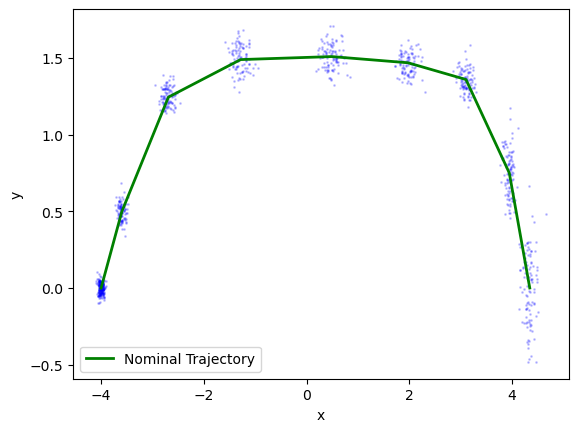

In [4]:
# Roll outs of the nominal trajectory with and without feedback

num_rollout = 100
error_signal_feedback = [None] * num_rollout
error_signal_openloop = [None] * num_rollout
output_trajectory_closedloop = [None] * num_rollout
input_trajectory_closedloop = [None] * num_rollout

unstacked_z = z_val
unstacked_v = v_val

plt.figure()

for rollout_cnt in range(num_rollout):
    # Open-loop rollout (no feedback)
    x = np.zeros((state_dim, T))
    for i in range(T - 1):
        noise = disturbance_level_dyn * (np.random.rand(state_dim) * 2 - 1)
        x[:, i + 1] = A_t @ x[:, i] + B_t @ unstacked_v[:, i] + noise
    error_signal_openloop[rollout_cnt] = np.vstack((x[0, :] - unstacked_z[0, :], x[1, :] - unstacked_z[1, :]))

    # Feedback rollout (with feedback)
    val_phi_ue = phi_ue.value.copy()
    val_phi_ue[np.isnan(val_phi_ue)] = 0
    val_phi_uw = phi_uw.value.copy()
    val_phi_uw[np.isnan(val_phi_uw)] = 0
    val_phi_xe = phi_xe.value
    val_phi_xw = phi_xw.value

    # Ensure the matrices are lower triangular
    # val_phi_xw = np.tril(val_phi_xw)
    # val_phi_xe = np.tril(val_phi_xe)
    # val_phi_uw = np.tril(val_phi_uw)
    # val_phi_ue = np.tril(val_phi_ue)
    # val_phi_xw = np.tril(val_phi_xw)



    # Feedback gain
    K = val_phi_ue - val_phi_uw @ np.linalg.solve(val_phi_xw, val_phi_xe)

    # Apply initial condition with disturbance
    x_init_fb = x_init + disturbance_level_dyn * (np.random.rand(state_dim) * 2 - 1).reshape((state_dim, 1))
    x_fb = np.zeros((state_dim, T))
    y_fb = np.zeros((output_dim, T))
    x_fb[:, 0] = x_init_fb.flatten()
    feedback_u = np.zeros((input_dim, T))

    for i in range(T):
        feedback_control = np.zeros(input_dim)
        y_fb[:, i] = C_t @ x_fb[:, i] + disturbance_level_output * (np.random.rand(output_dim) * 2 - 1)
        for j in range(i + 1):
            idx_K_row = slice(i * input_dim, (i + 1) * input_dim)
            idx_K_col = slice(j * output_dim, (j + 1) * output_dim)
            feedback_control += K[idx_K_row, idx_K_col] @ (y_fb[:, j] - C_t @ unstacked_z[:, j])
        dynamics_noise = disturbance_level_dyn * (np.random.rand(state_dim) * 2 - 1)
        if i < T - 1:
            x_fb[:, i + 1] = A_t @ x_fb[:, i] + B_t @ (feedback_control + unstacked_v[:, i]) + dynamics_noise
        feedback_u[:, i] = feedback_control
        

    plt.scatter(x_fb[0, :], x_fb[1, :], color="b", alpha=0.2, s = 1)
    # plt.scatter(x[0, :]-4, x[1, :], color="r", alpha=0.20, s=1, label="_nolegend_")

    error_signal_feedback[rollout_cnt] = np.vstack((x_fb[0, :] - unstacked_z[0, :], x_fb[1, :] - unstacked_z[1, :]))
    output_trajectory_closedloop[rollout_cnt] = y_fb
    input_trajectory_closedloop[rollout_cnt] = feedback_u

# Save the feedback gain K
# sio.savemat('K_forward_game.mat', {'K_forward': K})

import matplotlib as mpl
import matplotlib.pyplot as plt





plt.plot(unstacked_z[0, :], unstacked_z[1, :], color="g", label="Nominal Trajectory", linewidth=2)
# plt.axvline(x=state_poly_constraint[0], linestyle=":", color="k", linewidth=2)
plt.xlabel('x')
plt.ylabel('y')

# Use latex intepreter in legend
plt.legend()

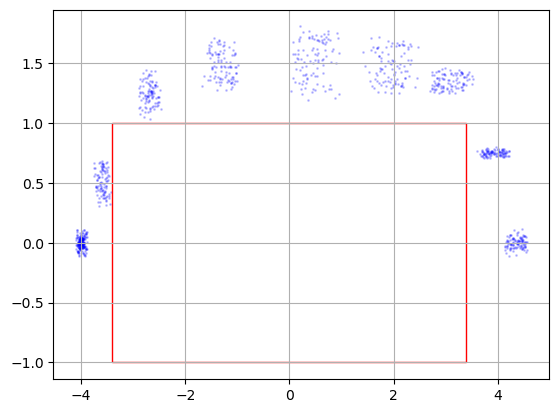

In [6]:
# Roll out directly with Phi matrices (not using K)
import matplotlib.patches as patches
import matplotlib.lines as mlines

num_rollout = 100
# error_signal_feedback = [None] * num_rollout
# error_signal_openloop = [None] * num_rollout
# output_trajectory_closedloop = [None] * num_rollout
# input_trajectory_closedloop = [None] * num_rollout

for rollout_cnt in range(num_rollout):
    x_fb = np.zeros((state_dim, T))
    # y_fb = np.zeros((output_dim, T))
    delta_x = np.zeros((state_dim, T))
    y_fb = np.zeros((output_dim, T))
    # delta_y = np.zeros((output_dim, T))
    x_fb[:, 0] = x_init.flatten() + disturbance_level_dyn * (np.random.rand(state_dim) * 2 - 1).reshape((state_dim, 1)).flatten()
    # y_fb[:, 0] = C_t @ x_fb[:, 0] + disturbance_level_output * (np.random.rand(output_dim) * 2 - 1).reshape((output_dim, 1))
    for i in range(T):
        dyn_noise = disturbance_level_dyn * (np.random.rand(state_dim) * 2 - 1).reshape((state_dim, 1))
        obs_noise = disturbance_level_output * (np.random.rand(output_dim) * 2 - 1).reshape((output_dim, 1))
        for j in range(i + 1):
            val_phi_xw_slice = val_phi_xw[i*state_dim:(i+1)*state_dim, j*state_dim:(j + 1)*state_dim]
            val_phi_xe_slice = val_phi_xe[i*state_dim:(i+1)*state_dim, j*output_dim:(j + 1)*output_dim]
            delta_x[:, i] += (val_phi_xw_slice @ dyn_noise).flatten() + (val_phi_xe_slice @ obs_noise).flatten()
        x_fb[:,i] = unstacked_z[:, i] + delta_x[:,i]
    # plt.plot(x_fb[0, :], x_fb[1, :], "b", alpha=0.2)
    # Plot the scatter plot of the feedback trajectory
    plt.scatter(x_fb[0, :], x_fb[1, :], color='blue', alpha=0.2, s=1)
box = patches.Rectangle((-xu, -yu), 2*xu, 2*yu
, linewidth=1, edgecolor='r', facecolor='none')
plt.gca().add_patch(box)
plt.grid()
plt.show()


In [ ]:
x_init

array([[-4.],
       [-0.],
       [ 0.],
       [ 0.]])

In [7]:
# Verify if K is lower triangular
if np.allclose(K, np.tril(K)):
    print("K is lower triangular.")
else:
    print("K is not lower triangular.")

print(np.linalg.norm(K - np.tril(K), ord='fro'))

K is lower triangular.
3.776004402437554e-15


In [8]:
# constraints += [(Id - Z@A) @ phi_xw - Z @ B @ phi_uw == Id]
# constraints += [(Id - Z@A) @ phi_xe - Z @ B @ phi_ue == np.zeros((T*input_dim, T*state_dim))]
# constraints += [phi_xw @ (Id - Z@A) - phi_xe @ C == Id]
# constraints += [phi_uw @ (Id - Z@A) - phi_ue @ C == np.zeros((T*input_dim, T*state_dim))]

# Display the sizes of the matrices
print("Size of phi_xw:", phi_xw.shape)
print("Size of phi_uw:", phi_uw.shape)  
print("Size of phi_xe:", phi_xe.shape)
print("Size of phi_ue:", phi_ue.shape)
# Display the sizes of the matrices Id, Z, A ,B and their products in the constraints
print("Size of Id:", Id.shape)
print("Size of Z:", Z.shape)
print("Size of A:", A.shape)
print("Size of B:", B.shape)
print("Size of (Id - Z@A):", (Id - Z@A).shape)
# Display the sizes of the products in the constraints
print("Size of (Id - Z@A) @ phi_xw:", ((Id - Z@A) @ phi_xw).shape)
print("Size of Z @ B @ phi_uw:", (Z @ B @ phi_uw).shape)
print("Size of (Id - Z@A) @ phi_xe:", ((Id - Z@A) @ phi_xe).shape)
print("Size of Z @ B @ phi_ue:", (Z @ B @ phi_ue).shape)

Size of phi_xw: (40, 40)
Size of phi_uw: (20, 40)
Size of phi_xe: (40, 20)
Size of phi_ue: (20, 20)
Size of Id: (40, 40)
Size of Z: (40, 40)
Size of A: (40, 40)
Size of B: (40, 20)
Size of (Id - Z@A): (40, 40)
Size of (Id - Z@A) @ phi_xw: (40, 40)
Size of Z @ B @ phi_uw: (40, 40)
Size of (Id - Z@A) @ phi_xe: (40, 20)
Size of Z @ B @ phi_ue: (40, 20)


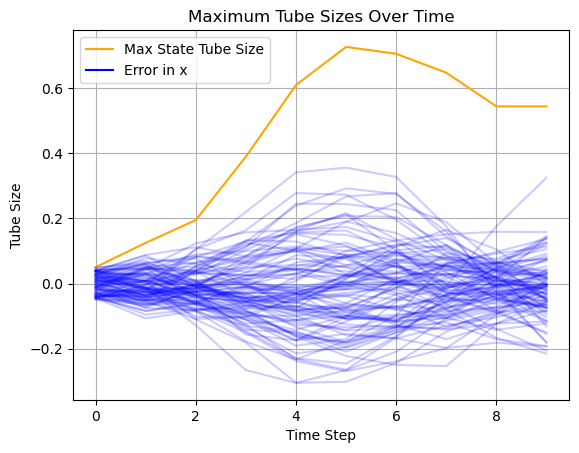

In [9]:
# Reachability analysis using the computed feedback gain
# Instantiate the noise value as decision variables

w = cp.Variable((T * state_dim, 1))
e = cp.Variable((T * output_dim, 1))

# Maximum tube size at each time step, use a list instead of a NumPy array
max_state_tube_size = []
max_input_tube_size = []
# Initialize the maximum tube sizes as zero
for k in range(T):
    max_state_tube_size.append(0)
    max_input_tube_size.append(0)

# Instantiate the results container of the maximum tube sizes
val_max_state_tube_size = np.zeros((T, 1))
val_max_state_tube_size = np.zeros((T, 1))
constraints = []

constraints += [cp.norm_inf(w) <= disturbance_level_dyn]
constraints += [cp.norm_inf(e) <= disturbance_level_output]

# Compute the maximum tube size
for k in range(T):  

    # Bound the infinity norm of the noise level
    max_state_tube_size[k] = np.zeros((2,1))
    max_input_tube_size[k] = 0
    
    for j in range(k + 1):


        w_j = w[j*state_dim:(j+1)*state_dim]
        e_j = e[j*output_dim:(j+1)*output_dim]


        phi_kxwj = val_phi_xw[k*state_dim:(k+1)*state_dim, j*state_dim:(j+1)*state_dim]
        phi_kxej = val_phi_xe[k*state_dim:(k+1)*state_dim, j*output_dim:(j+1)*output_dim]
        phi_kuwj = val_phi_uw[k*input_dim:(k+1)*input_dim, j*state_dim:(j+1)*state_dim]
        phi_kuej = val_phi_ue[k*input_dim:(k+1)*input_dim, j*output_dim:(j+1)*output_dim]

        # Compute the maximum state tube size

        max_state_tube_size[k][0] = max_state_tube_size[k][0] + disturbance_level_dyn * np.abs(phi_kxwj[0,:]) @ np.ones((state_dim,)) + disturbance_level_output * np.abs(phi_kxej[0,:]) @ np.ones((output_dim,))
        max_state_tube_size[k][1] = max_state_tube_size[k][1] + disturbance_level_dyn * np.abs(phi_kxwj[1,:]) @ np.ones((state_dim,)) + disturbance_level_output * np.abs(phi_kxej[1,:]) @ np.ones((output_dim,))

        # Compute the maximum input tube size
        max_input_tube_size[k] = max_input_tube_size[k] + phi_kuwj @ w_j + phi_kuej @ e_j


        # max_state_tube_size[k] = max_state_tube_size[k] + phi_kxwj @ w_j + phi_kxej @ e_j
        # # Compute the maximum input tube size
        # max_input_tube_size[k] = max_input_tube_size[k] + phi_kuwj @ w_j + phi_kuej @ e_j
    
    # Maximize the tube sizes via cvxpy, which is done at each time step
    # We need to generate a cvxproblem and solve it
    # Add the constraints to the problem
    # Use the epigraph trick to avoid DCP problems
    # constraints += [t >= max_input_tube_size[k]]
    # Define the problem

    # prob_state = cp.Problem(cp.Maximize(cp.norm(max_state_tube_size[k])), constraints)
    # prob_state.solve(solver=cp.GUROBI, verbose=False)
    # val_max_state_tube_size[k] = max_state_tube_size[k].value




# Plot the maximum tube sizes at different time steps, plot the error signal of the rollouts
plt.figure(1)
plt.plot([expr[0] for expr in max_state_tube_size], label='Max State Tube Size', color='orange')
# plt.plot([expr.value for expr in max_input_tube_size], label='Max Input Tube Size', color='blue')
plt.xlabel('Time Step')
plt.ylabel('Tube Size')
plt.title('Maximum Tube Sizes Over Time')
plt.legend()
plt.grid()

# Plot the error signals of the rollouts
for rollout_cnt in range(num_rollout):
    plt.plot(error_signal_feedback[rollout_cnt][0, :], 'b', alpha=0.2)
    # plt.plot(error_signal_feedback[rollout_cnt][1, :], 'r', alpha=0.2)
plt.plot([], [], 'b', label='Error in x')
# plt.plot([], [], 'r', label='Error in y')
plt.legend()
plt.show() 

# plt.figure(3)
# for rollout_cnt in range(num_rollout):
#     plt.plot(error_signal_openloop[rollout_cnt][0, :], error_signal_openloop[rollout_cnt][1, :], 'r', alpha=0.2)
# plt.xlabel('Error in x')
# plt.ylabel('Error in y')
# plt.title('Error Signal of Open-loop Rollouts')
# plt.grid()
# plt.show()


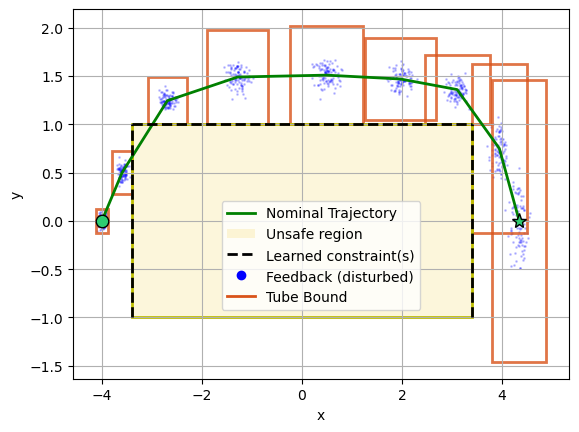

In [10]:
# Roll outs of the nominal trajectory with and without feedback

num_rollout = 100
error_signal_feedback = [None] * num_rollout
error_signal_openloop = [None] * num_rollout
output_trajectory_closedloop = [None] * num_rollout
input_trajectory_closedloop = [None] * num_rollout

unstacked_z = z_val
unstacked_v = v_val

fig = plt.figure()

for rollout_cnt in range(num_rollout):
    # Open-loop rollout (no feedback)
    x = np.zeros((state_dim, T))
    for i in range(T - 1):
        noise = disturbance_level_dyn * (np.random.rand(state_dim) * 2 - 1)
        x[:, i + 1] = A_t @ x[:, i] + B_t @ unstacked_v[:, i] + noise
    error_signal_openloop[rollout_cnt] = np.vstack((x[0, :] - unstacked_z[0, :], x[1, :] - unstacked_z[1, :]))

    # Feedback rollout (with feedback)
    val_phi_ue = phi_ue.value.copy()
    val_phi_ue[np.isnan(val_phi_ue)] = 0
    val_phi_uw = phi_uw.value.copy()
    val_phi_uw[np.isnan(val_phi_uw)] = 0
    val_phi_xe = phi_xe.value
    val_phi_xw = phi_xw.value

    # Ensure the matrices are lower triangular
    # val_phi_xw = np.tril(val_phi_xw)
    # val_phi_xe = np.tril(val_phi_xe)
    # val_phi_uw = np.tril(val_phi_uw)
    # val_phi_ue = np.tril(val_phi_ue)
    # val_phi_xw = np.tril(val_phi_xw)



    # Feedback gain
    K = val_phi_ue - val_phi_uw @ np.linalg.solve(val_phi_xw, val_phi_xe)

    # Apply initial condition with disturbance
    x_init_fb = x_init + disturbance_level_dyn * (np.random.rand(state_dim) * 2 - 1).reshape((state_dim, 1))
    x_fb = np.zeros((state_dim, T))
    y_fb = np.zeros((output_dim, T))
    x_fb[:, 0] = x_init_fb.flatten()
    feedback_u = np.zeros((input_dim, T))

    for i in range(T):
        feedback_control = np.zeros(input_dim)
        y_fb[:, i] = C_t @ x_fb[:, i] + disturbance_level_output * (np.random.rand(output_dim) * 2 - 1)
        for j in range(i + 1):
            idx_K_row = slice(i * input_dim, (i + 1) * input_dim)
            idx_K_col = slice(j * output_dim, (j + 1) * output_dim)
            feedback_control += K[idx_K_row, idx_K_col] @ (y_fb[:, j] - C_t @ unstacked_z[:, j])
        dynamics_noise = disturbance_level_dyn * (np.random.rand(state_dim) * 2 - 1)
        if i < T - 1:
            x_fb[:, i + 1] = A_t @ x_fb[:, i] + B_t @ (feedback_control + unstacked_v[:, i]) + dynamics_noise
        feedback_u[:, i] = feedback_control
        

    plt.scatter(x_fb[0, :], x_fb[1, :], color="b", alpha=0.2, s = 1)
    # plt.scatter(x[0, :]-4, x[1, :], color="r", alpha=0.20, s=1, label="_nolegend_")

    error_signal_feedback[rollout_cnt] = np.vstack((x_fb[0, :] - unstacked_z[0, :], x_fb[1, :] - unstacked_z[1, :]))
    output_trajectory_closedloop[rollout_cnt] = y_fb
    input_trajectory_closedloop[rollout_cnt] = feedback_u

# Save the feedback gain K
# sio.savemat('K_forward_game.mat', {'K_forward': K})

import matplotlib as mpl
import matplotlib.pyplot as plt





plt.plot(unstacked_z[0, :], unstacked_z[1, :], color="g", label="Nominal Trajectory", linewidth=2)

# Plot max tube size as a box around the nominal trajectory
for k in range(T):
    box = patches.Rectangle((unstacked_z[0, k] - max_state_tube_size[k][0], unstacked_z[1, k] - max_state_tube_size[k][1]), 
                            2 * max_state_tube_size[k][0], 2 * max_state_tube_size[k][1],
                            linewidth=2, edgecolor='#D95319', facecolor='none', alpha=0.8)
    plt.gca().add_patch(box)



# plt.axvline(x=state_poly_constraint[0], linestyle=":", color="k", linewidth=2)
plt.xlabel('x')
plt.ylabel('y')

# Use latex intepreter in legend
plt.legend()


# --- Add-ons for publication-quality figure (no changes to your existing code) ---
import matplotlib.patches as patches
import matplotlib.lines as mlines

ax = plt.gca()

# 1) Start / End markers on the nominal trajectory
h_start = ax.plot(unstacked_z[0, 0],  unstacked_z[1, 0],
                  marker='o', markersize=9, linestyle='none',
                  markerfacecolor='#2ECC71', markeredgecolor='k')[0]

h_goal  = ax.plot(unstacked_z[0, -1], unstacked_z[1, -1],
                  marker='*', markersize=11, linestyle='none',
                  markerfacecolor='#2ECC71', markeredgecolor='k')[0]

# 2) Shade the inside of the box as an unsafe region (behind all curves)
unsafe_patch = patches.Rectangle((-xu, -yu), 2*xu, 2*yu,
                                 facecolor='#F1C40F', alpha=0.15,
                                 edgecolor='none', zorder=0, label='Unsafe region')
ax.add_patch(unsafe_patch)

# 3) Learned constraints: left, bottom, right edges (dashed black)
lc_left  = ax.plot([-xu, -xu], [-yu,  yu], '--', color='k', linewidth=2,
                   label='Learned constraint(s)')[0]
ax.plot([-xu,  xu], [yu, yu], '--', color='k', linewidth=2, label='_nolegend_')
ax.plot([ xu,  xu], [-yu,  yu], '--', color='k', linewidth=2, label='_nolegend_')

# 4) Legend: add entries for feedback/open-loop rollouts via dummy handles (so you don't get 100 items)
# This handle is for feedback rollouts, should be scatter blue
fb_handle = mlines.Line2D([], [], color='b', marker='o', linestyle='none', markersize=6, label='Feedback (disturbed)')

# fb_handle = mlines.Line2D([], [], color='b', linewidth=2, label='Feedback (disturbed)')
# ol_handle = mlines.Line2D([], [], color='r', linewidth=2, label='Open-loop (disturbed)')

tube_handle = mlines.Line2D([], [], color='#D95319', linewidth=2, label='Tube Bound')



# Collect current handles & labels, append our new ones, and de-duplicate by label
handles, labels = ax.get_legend_handles_labels()
handles += [fb_handle, unsafe_patch, lc_left,tube_handle]
labels  += [h.get_label() for h in [fb_handle, unsafe_patch, lc_left,tube_handle]]

uniq = {}
for h, lab in zip(handles, labels):
    if lab not in ('_nolegend_', ''):
        uniq[lab] = h
ax.legend(uniq.values(), uniq.keys(), loc='upper center',
                bbox_to_anchor=(0.5, 0.5),   # ↓ lower this number to move down
                frameon=True)

ax.grid(True)

box = patches.Rectangle((-xu, -yu), 2*xu, 2*yu
, linewidth=2, edgecolor='y', facecolor='none')
ax.add_patch(box)
ax.grid(True)


# plt.savefig('SLS_DI_outputfeedback.pdf')  # standard
plt.show()
fig.savefig('SLS_DI_outputfeedback_withtube.pdf', bbox_inches='tight')  # with tube